In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import random

import mysklearn.myutils as myutils
import mysklearn.plotutils as plotutils
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers as myclassifiers
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyNaiveBayesClassifier

import mysklearn.myevaluation as myevaluation

First, we loaded in our sampled and cleaned data.

In [5]:
spotify_table = MyPyTable()
spotify_table.load_from_file("./input_data/sampled_cleaned_spotify_tracks.csv")

In [7]:
df = pd.read_csv("./input_data/sampled_cleaned_spotify_tracks.csv")
corr_df = df.corr()
corr_df.style.background_gradient(cmap="coolwarm").set_precision(2)

/tmp/ipykernel_24315/1660192116.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient(cmap="coolwarm").set_precision(2)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
popularity,1.00,-0.04,0.15,0.14,0.13,-0.03,0.18,-0.03,0.04,-0.18,-0.17,-0.02,0.06,0.00,0.01
duration_ms,-0.04,1.00,-0.07,-0.18,0.09,0.00,0.05,0.02,-0.16,-0.07,0.02,-0.04,-0.17,0.02,-0.01
explicit,0.15,-0.07,1.00,0.19,0.07,-0.03,0.08,-0.03,0.35,-0.06,-0.07,0.04,0.07,0.02,0.03
danceability,0.14,-0.18,0.19,1.00,0.12,0.05,0.27,-0.14,0.23,-0.15,-0.24,-0.09,0.48,-0.11,0.22
energy,0.13,0.09,0.07,0.12,1.00,0.08,0.76,-0.13,0.15,-0.74,-0.34,0.21,0.37,0.20,0.17
key,-0.03,0.00,-0.03,0.05,0.08,1.00,0.05,-0.09,0.02,-0.08,-0.01,0.03,0.10,0.02,0.01
loudness,0.18,0.05,0.08,0.27,0.76,0.05,1.00,-0.11,0.12,-0.60,-0.58,0.14,0.30,0.24,0.20
mode,-0.03,0.02,-0.03,-0.14,-0.13,-0.09,-0.11,1.00,-0.06,0.12,0.01,-0.02,-0.10,-0.04,0.01
speechiness,0.04,-0.16,0.35,0.23,0.15,0.02,0.12,-0.06,1.00,-0.10,-0.10,0.06,0.17,0.16,0.06
acousticness,-0.18,-0.07,-0.06,-0.15,-0.74,-0.08,-0.60,0.12,-0.10,1.00,0.28,-0.14,-0.25,-0.17,-0.15


Looking at the popularity column, it looked like popularity has the highest correlations (in decending order) with acousticness, loudness, instrumentalness, explicit, danceability, and energy. We looked closer at these relationships. "Explicit" was in string format ("True" or "False") and had to be represented numerically (1=T 0=F) for the scatterplot, so we made a new list to track and graph the numeric representation of "explicit".

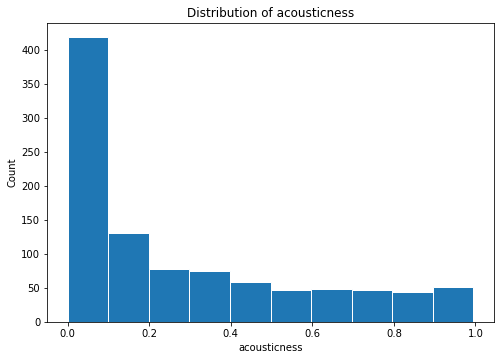

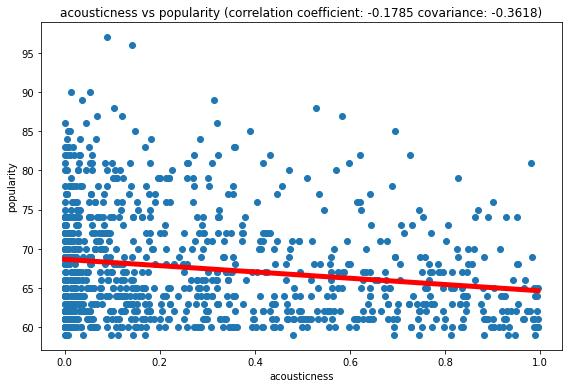

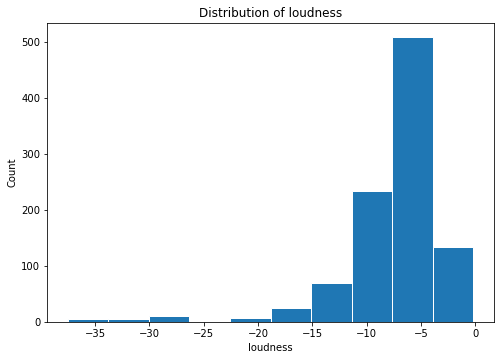

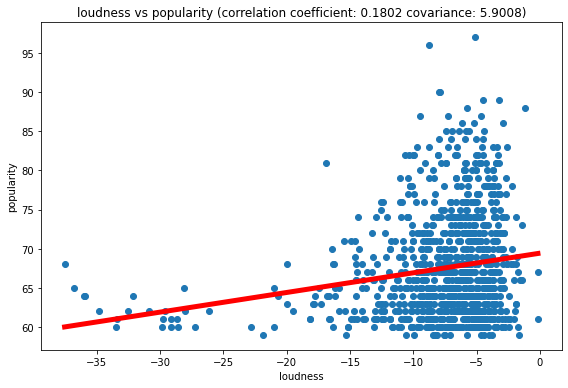

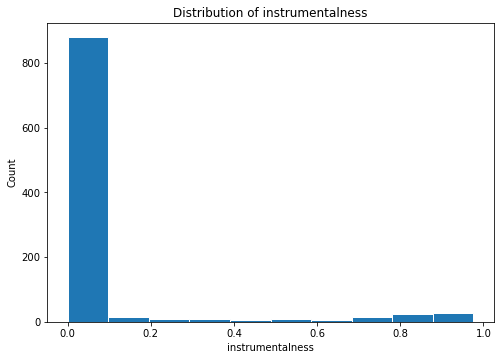

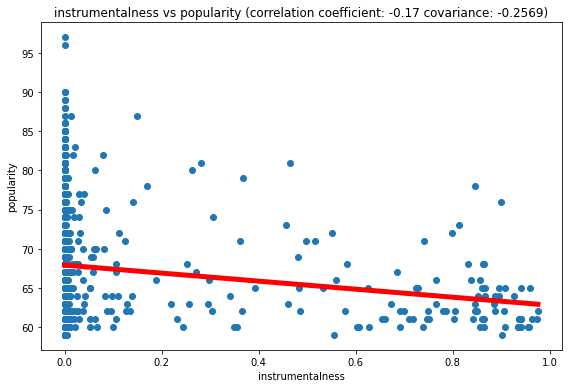

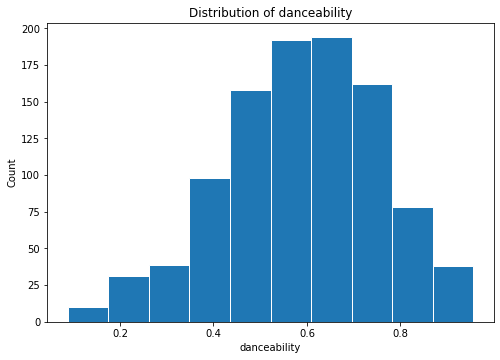

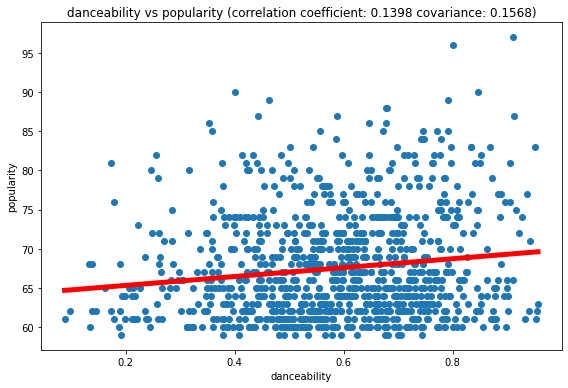

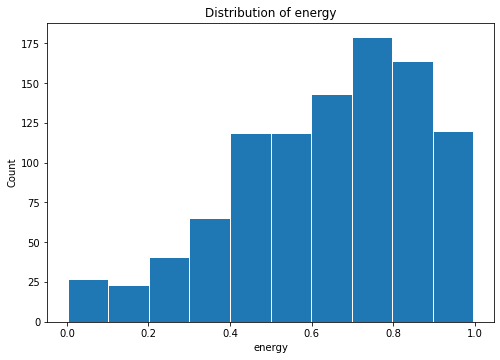

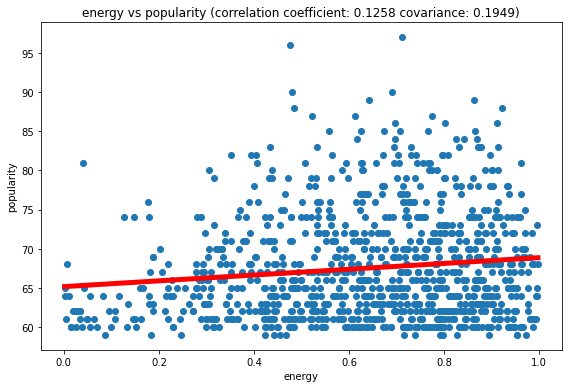

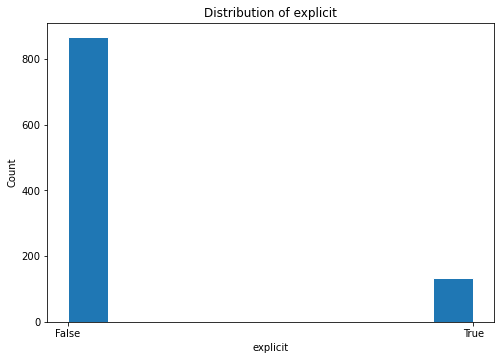

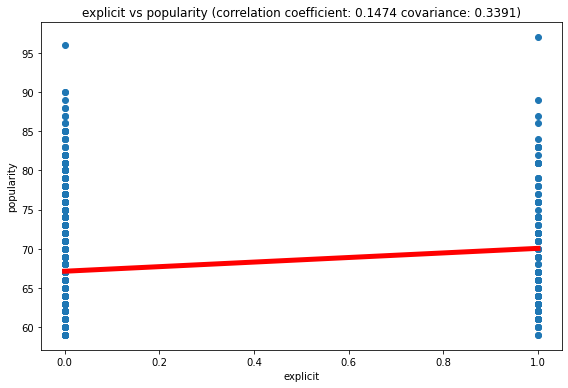

In [26]:
importlib.reload(myutils)
importlib.reload(plotutils)

explicit_col = spotify_table.get_column("explicit")
explicit_nums = []
for value in explicit_col:
    if value == "True":
        explicit_nums.append(1)
    else:
        explicit_nums.append(0)

attributes = ["acousticness", "loudness", "instrumentalness", "danceability", "energy"]
for attbt in attributes:
    plotutils.histogram(spotify_table, attbt, attbt)
    plotutils.scatter_plot(spotify_table, attbt, "popularity")
# explicit column had to be handled separately because it was in string form
plotutils.histogram(spotify_table, "explicit", "explicit")
plotutils.scatter_plot(spotify_table, explicit_nums, spotify_table.get_column("popularity"), labels=["explicit", "popularity"])

Based on the above graphs, acousticness, loudness, and instrumentalness had the most correlation with popularity (correlation coefficients of +/- 0.17 or 0.18) followed by explicit, danceability, and energy (correlation coefficients of 0.12 - 0.15). After looking at these relationships, we were prepared to discretize our data in order to make it useable for our classifiers.

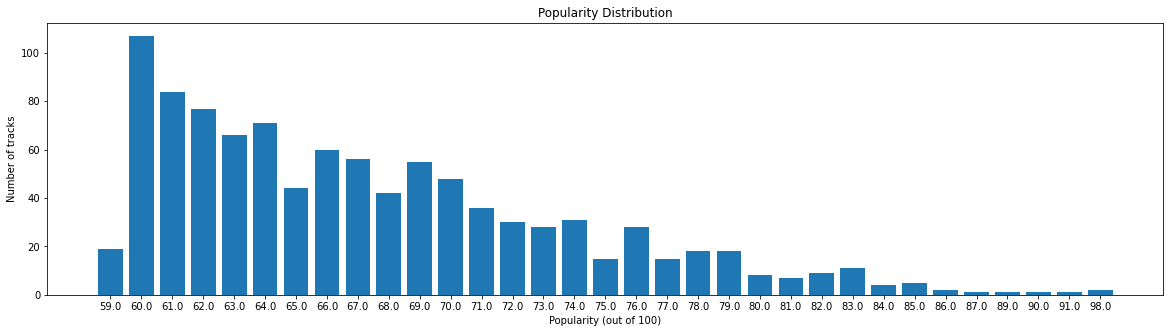

In [18]:
importlib.reload(myutils)

popularity_column = spotify_table.get_column("popularity")
unique_popularities = sorted(myutils.get_unique_values(popularity_column))
frequencies = myutils.get_frequency_of_multiple_values(unique_popularities, popularity_column)
plotutils.simple_bar_chart(unique_popularities, frequencies, ["Popularity (out of 100)", "Number of tracks", "Popularity Distribution"])

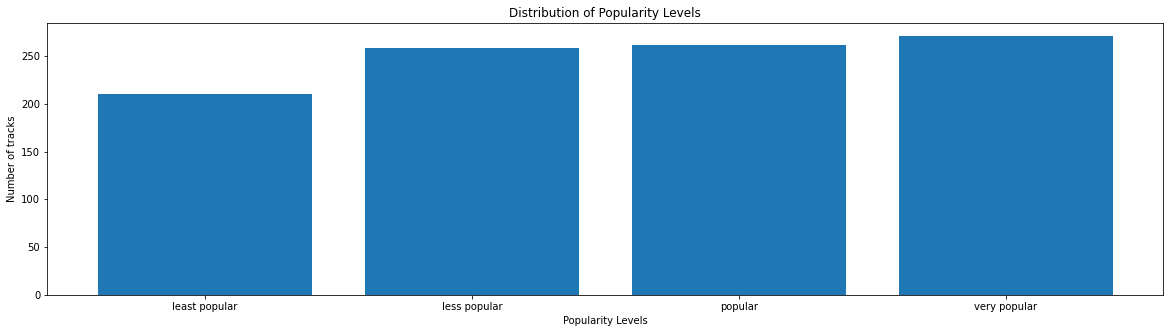

In [19]:
importlib.reload(myutils)

cutoffs = myutils.compute_equal_frequency_cutoffs(sorted(popularity_column), 4)
discretized_popularities = myutils.discretize_with_cut_offs(popularity_column, cutoffs)
unique_discretized_popularities = sorted(myutils.get_unique_values(discretized_popularities))
frequencies_discretized_popularities = myutils.get_frequency_of_multiple_values(unique_discretized_popularities, discretized_popularities)
plotutils.simple_bar_chart(unique_discretized_popularities, frequencies_discretized_popularities, ["Popularity Levels", \
    "Number of tracks", "Distribution of Popularity Levels"])

In [22]:
importlib.reload(myutils)
importlib.reload(myclassifiers)

X_data = [[instance[spotify_table.column_names.index("track_genre")], 
          instance[spotify_table.column_names.index("energy")],
          instance[spotify_table.column_names.index("danceability")],
          instance[spotify_table.column_names.index("liveness")]] for instance in spotify_table.data]
print(X_data[:20])
nb_accuracy = 0
nb_predictions, y_actual = [], []
skfold_splits = myutils.strat_cross_val_predict(10, X_data, discretized_popularities, 10)
for skfold_split in skfold_splits:
    for split in skfold_split:
        nb_clf = MyNaiveBayesClassifier()
        nb_clf.fit(split[0], split[2])
        predictions_naive = nb_clf.predict(split[1])
        nb_accuracy += myevaluation.accuracy_score(split[3], predictions_naive)
        y_actual += split[3]
        nb_predictions += predictions_naive

[['progressive-house', 0.912, 0.727, 0.118], ['country', 0.681, 0.377, 0.0504], ['reggae', 0.606, 0.853, 0.313], ['k-pop', 0.733, 0.791, 0.0423], ['indie-pop', 0.876, 0.636, 0.117], ['acoustic', 0.407, 0.66, 0.109], ['indie-pop', 0.541, 0.677, 0.125], ['british', 0.403, 0.443, 0.111], ['turkish', 0.582, 0.966, 0.112], ['synth-pop', 0.814, 0.706, 0.262], ['dancehall', 0.875, 0.816, 0.0346], ['disco', 0.703, 0.601, 0.571], ['chill', 0.294, 0.619, 0.103], ['soul', 0.363, 0.86, 0.101], ['metal', 0.997, 0.293, 0.415], ['rock-n-roll', 0.318, 0.576, 0.167], ['disco', 0.459, 0.918, 0.0532], ['j-pop', 0.669, 0.682, 0.145], ['british', 0.869, 0.576, 0.0573], ['blues', 0.885, 0.58, 0.146]]


In [21]:
importlib.reload(myutils)

print("Naive Bayes classifier: accuracy =", nb_accuracy/100, ", error rate =", 1 - nb_accuracy/100, \
    "\n\tprecision rate =", myevaluation.binary_precision_score(y_actual, nb_predictions), \
    ", recall = ", myevaluation.binary_recall_score(y_actual, nb_predictions), \
    ", F1 = ", myevaluation.binary_f1_score(y_actual, nb_predictions))

Naive Bayes classifier: accuracy = 0.35800000000000004 , error rate = 0.6419999999999999 
	precision rate = 0.3228346456692913 , recall =  0.3904761904761905 , F1 =  0.35344827586206895
